In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import chess
import chess.pgn
import copy
import time
import os

# Parallel processing library
from joblib import Parallel, delayed

# Check Device
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print(f"CPU Cores Available: {os.cpu_count()}")

# Global Device Setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device:", device)



Torch: 2.6.0+cu124
CUDA available: True
CPU Cores Available: 6
Training Device: cuda


In [ ]:

#  The Neural Network 

class ReLearnNet(nn.Module):
    def __init__(self, num_possible_moves=4672, dropout_prob=0.2):
        super(ReLearnNet, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout_prob)

        # --- Shared Layers ---
        self.conv1 = nn.Conv2d(12, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # --- Policy Head ---
        self.policy_conv = nn.Conv2d(256, 2, kernel_size=1) 
        self.policy_bn = nn.BatchNorm2d(2)
        self.policy_fc = nn.Linear(2 * 8 * 8, num_possible_moves)

        # --- Value Head ---
        self.value_conv = nn.Conv2d(256, 1, kernel_size=1)
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(1 * 8 * 8, 64)
        self.value_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Shared Layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # --- Policy Head ---
        p = F.relu(self.policy_bn(self.policy_conv(x)))
        p = p.view(-1, 2 * 8 * 8) 
        
        p = self.dropout(p) 
        
        p = self.policy_fc(p)
        p = F.log_softmax(p, dim=1) 

        # --- Value Head ---
        v = F.relu(self.value_bn(self.value_conv(x)))
        v = v.view(-1, 1 * 8 * 8) 
        
        v = F.relu(self.value_fc1(v))
        
        v = self.dropout(v)
        
        v = torch.tanh(self.value_fc2(v)) 

        return p, v

In [68]:
# %%
# --- 2. The Move Encoder ---

class AlphaZeroChessEncoding:
    """
    Encodes chess moves into the 8x8x73 (4672) integer action space.
    """
    def __init__(self):
        self.queen_dirs = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]
        self.knight_moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
        self.under_promotions = [chess.KNIGHT, chess.BISHOP, chess.ROOK]
        self.under_promo_dirs = [0, -1, 1] 

    def encode(self, move: chess.Move, board: chess.Board) -> int:
        from_sq = move.from_square
        to_sq = move.to_square
        
        delta_rank = chess.square_rank(to_sq) - chess.square_rank(from_sq)
        delta_file = chess.square_file(to_sq) - chess.square_file(from_sq)
        
        if board.turn == chess.BLACK:
            delta_rank *= -1
            delta_file *= -1

        plane_idx = -1
        is_knight = board.piece_type_at(from_sq) == chess.KNIGHT
        is_promo = bool(move.promotion)

        if is_promo and move.promotion in self.under_promotions:
            promo_idx = self.under_promotions.index(move.promotion)
            dir_idx = self.under_promo_dirs.index(delta_file)
            plane_idx = 64 + (dir_idx * 3) + promo_idx

        elif is_knight:
            try:
                k_idx = self.knight_moves.index((delta_rank, delta_file))
                plane_idx = 56 + k_idx
            except ValueError:
                return None 

        else:
            dist = max(abs(delta_rank), abs(delta_file))
            if dist == 0: return None
            
            d_rank = delta_rank // dist
            d_file = delta_file // dist
            
            try:
                dir_idx = self.queen_dirs.index((d_rank, d_file))
                plane_idx = (dir_idx * 7) + (dist - 1)
            except ValueError:
                return None 

        final_from_sq = from_sq
        if board.turn == chess.BLACK:
            final_from_sq = 63 - from_sq
            
        return (final_from_sq * 73) + plane_idx

encoder = AlphaZeroChessEncoding()



In [69]:
# %%
# --- 3. Optimized Helpers ---

def board_to_tensor_fast(board):
    """
    Optimized version of board_to_tensor using numpy pre-allocation.
    """
    piece_map = {
        chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
        chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5
    }
    
    matrix = np.zeros((12, 8, 8), dtype=np.float32)
    
    for square, piece in board.piece_map().items():
        rank = chess.square_rank(square)
        file = chess.square_file(square)
        layer = piece_map[piece.piece_type]
        
        if piece.color == chess.BLACK:
            layer += 6
            
        matrix[layer, rank, file] = 1.0

    return torch.tensor(matrix).unsqueeze(0) 

def pick_move(move_probs):
    """Pick move based on probability."""
    best_move = None
    max_prob = -1.0
    for move, prob in move_probs:
        if prob > max_prob:
            max_prob = prob
            best_move = move
    return best_move

def calc_ucb1_scores(nodes, N, C=2):
    """Calculate UCB1 scores."""
    ucb1_scores = []
    node_list = []
    
    for move, node in nodes.items():
        if node.visits == 0:
            score = float('inf')
        else:
            exploit = node.avg_value() 
            explore = C * node.prior * np.sqrt(np.log(N) / node.visits)
            score = exploit + explore
            
        ucb1_scores.append(score)
        node_list.append(node)

    return node_list, ucb1_scores



In [ ]:
# MCTS 

class Mcts_Node:
    def __init__(self, player_turn, board_state, prior=None):
        self.prior = prior
        self.player_turn = player_turn
        self.children = {}
        self.visits = 0
        self.valuesum = 0
        self.board_state = board_state

    def avg_value(self):
        if self.visits == 0: return 0
        return self.player_turn * self.valuesum / self.visits
    
    def expand(self, moves, priors):
        for i, move in enumerate(moves):

            new_board = self.board_state.copy(stack=False)
            new_board.push(move)
            self.children[move] = Mcts_Node(self.player_turn * -1, new_board, priors[i])

class MCTS:
    def __init__(self, model, initial_board_state, player_turn, n_searches, device):
        self.root = Mcts_Node(player_turn, initial_board_state, prior=1.0)
        self.n_searches = n_searches
        self.model = model
        self.device = device
        self.transposition_table = {}

    def search(self):
        with torch.no_grad():
            for n in range(self.n_searches):
                current_node = self.root
                search_history = [self.root]

                # Selection
                while len(current_node.children) != 0:
                    node_list, ucb1_scores = calc_ucb1_scores(current_node.children, current_node.visits)
                    best_state_index = np.argmax(ucb1_scores)
                    current_node = node_list[best_state_index]
                    search_history.append(current_node)

                # Check Transposition Table
                board_fen = current_node.board_state.fen()
                
                if board_fen in self.transposition_table:
                    legal_moves, priors, val = self.transposition_table[board_fen]
                else:
                    # Evaluation
                    board_tensor = board_to_tensor_fast(current_node.board_state).to(self.device)
                    log_policy, val_tensor = self.model(board_tensor)
                    val = val_tensor.item()
                    
                    all_move_probs = torch.exp(log_policy).squeeze(0).cpu().numpy()
                    legal_moves = list(current_node.board_state.legal_moves)
                    priors = []
                    
                    for move in legal_moves:
                        move_idx = encoder.encode(move, current_node.board_state)
                        if move_idx is not None:
                            priors.append(all_move_probs[move_idx])
                        else:
                            priors.append(0.0)
                    
                    total = sum(priors)
                    if total > 0:
                        priors = [p / total for p in priors]
                        
                    self.transposition_table[board_fen] = (legal_moves, priors, val)

                # Expansion
                if not current_node.board_state.is_game_over():
                    current_node.expand(legal_moves, priors)

                # Backup
                for node in reversed(search_history):
                    node.visits += 1
                    node.valuesum += val

    def get_children_probs(self):
        total_visits = sum(child.visits for child in self.root.children.values())
        probs = []
        for move, child_node in self.root.children.items():
            p = child_node.visits / total_visits
            probs.append((move, p))
        return probs



In [ ]:

# Parallel Processing Helper Functions 

# This function runs on a separate CPU core
def play_single_game(model_state_dict, n_searches):
    """
    Plays one full game of self-play.
    Instantiates its own local model to avoid locking issues.
    """
    # Create local model instance on CPU
    local_model = ReLearnNet()
    local_model.load_state_dict(model_state_dict)
    local_model.eval()
    
    board = chess.Board()
    game_history = []
    player_turn = 1
    
    cpu_device = torch.device('cpu')
    
    # Init MCTS
    mcts = MCTS(local_model, board, player_turn, n_searches=n_searches, device=cpu_device)
    
    while not board.is_game_over():
        mcts.search()
        
        # Get visit counts
        probs = mcts.get_children_probs()
        move = pick_move(probs)
        
        # Encode Policy Target
        policy_target = np.zeros(4672, dtype=np.float32)
        for m, p in probs:
            idx = encoder.encode(m, board)
            if idx is not None: policy_target[idx] = p
            
        # Store Data
        game_history.append([
            board_to_tensor_fast(board), 
            torch.tensor(policy_target), 
            None
        ])
        
        board.push(move)
        player_turn *= -1
        
        mcts = MCTS(local_model, board, player_turn, n_searches=n_searches, device=cpu_device)

    # Determine Winner
    result = board.outcome()
    if result.winner == chess.WHITE: score = 1
    elif result.winner == chess.BLACK: score = -1
    else: score = 0

    # Assign Result to all steps
    final_data = []
    for step in game_history:
        step[2] = torch.tensor([score], dtype=torch.float32)
        final_data.append(step)
        
    return final_data



In [ ]:

# Main Training Loop 

def train_step(model, optimizer, training_data, batch_size=32, epochs=1):
    model.train()
    
    states, policies, values = zip(*training_data)
    
    states_batch = torch.cat(states, dim=0).to(device)
    policies_batch = torch.stack(policies).to(device)
    values_batch = torch.stack(values).to(device)
    
    dataset = TensorDataset(states_batch, policies_batch, values_batch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_loss = 0
    for _ in range(epochs):
        for batch_s, batch_p, batch_v in dataloader:
            pred_log_pis, pred_vs = model(batch_s)
            
            loss_v = F.mse_loss(pred_vs, batch_v)
            loss_p = -torch.mean(torch.sum(batch_p * pred_log_pis, dim=1))
            loss = loss_v + loss_p
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
    return total_loss / (len(dataloader) * epochs)

def training_loop(model, optimizer, total_iterations):
    print(f"Starting Parallel Training...")
    
    NUM_CORES = 6
    GAMES_PER_BATCH = 36 
    
    for i in range(total_iterations):
        print(f"\n--- Iteration {i+1}/{total_iterations} ---")
        start_time = time.time()
        
        # 1. Self Play (Parallelized)
        print(f"  Parallel Self-Play ({NUM_CORES} cores)...")
        
        model_weights = model.to('cpu').state_dict()
        
        parallel_games_data = Parallel(n_jobs=NUM_CORES)(
            delayed(play_single_game)(model_weights, n_searches=400) 
            for _ in range(GAMES_PER_BATCH)
        )

        training_data = [item for sublist in parallel_games_data for item in sublist]
        
        print(f"  Generated {len(training_data)} positions in {time.time()-start_time:.1f}s.")
        
        # 2. Training (GPU)
        print("  Training...")
        model.to(device) 
        
        avg_loss = train_step(model, optimizer, training_data, batch_size=32, epochs=4)
        print(f"  Loss: {avg_loss:.4f}")
        
        # Save Checkpoint
        if (i+1) % 10 == 0:
            torch.save(model.state_dict(), f"chess_checkpoint_{i+1}.pth")

    return model



In [ ]:
# %%
# --- 7. Execution ---

# Initialize
model = ReLearnNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

final_model = training_loop(model, optimizer, total_iterations=200)

# Save Final Model
torch.save(final_model.state_dict(), "chess_model_final_parallel.pth")
print("Training Complete!")



Starting Parallel Training...

--- Iteration 1/200 ---
  Parallel Self-Play (6 cores)...
  Generated 1800 positions in 549.3s.
  Training...
  Loss: 4.0195

--- Iteration 2/200 ---
  Parallel Self-Play (6 cores)...
  Generated 1368 positions in 411.6s.
  Training...
  Loss: 2.8598

--- Iteration 3/200 ---
  Parallel Self-Play (6 cores)...
  Generated 3780 positions in 1191.2s.
  Training...
  Loss: 2.3427

--- Iteration 4/200 ---
  Parallel Self-Play (6 cores)...
  Generated 1800 positions in 574.0s.
  Training...
  Loss: 1.7165

--- Iteration 5/200 ---
  Parallel Self-Play (6 cores)...
  Generated 2088 positions in 669.0s.
  Training...
  Loss: 1.4244

--- Iteration 6/200 ---
  Parallel Self-Play (6 cores)...
  Generated 1584 positions in 487.8s.
  Training...
  Loss: 1.4743

--- Iteration 7/200 ---
  Parallel Self-Play (6 cores)...
  Generated 2808 positions in 905.6s.
  Training...
  Loss: 1.3245

--- Iteration 8/200 ---
  Parallel Self-Play (6 cores)...
  Generated 2304 positions i

KeyboardInterrupt: 

In [ ]:
#  Helper: Get AI Move 
def get_ai_move(board, model_path="chess_checkpoint_10_best_so_far.pth", n_searches=100):
    """
    Loads model and returns best move for the board.
    """
    # Initialize Architecture
    model = ReLearnNet()
    
    # Load Weights (Map to CPU for inference)
    try:
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint)
    except FileNotFoundError:
        print("Model file not found. Please train first.")
        return None
        
    model.eval()
    
    # Initialize MCTS
    # Player turn: 1 = White, -1 = Black
    player_turn = 1 if board.turn == chess.WHITE else -1
    mcts = MCTS(model, board, player_turn, n_searches=n_searches, device=torch.device('cpu'))
    
    # Search and Pick
    mcts.search()
    probs = mcts.get_children_probs()
    best_move = pick_move(probs)
    
    return best_move



In [ ]:
loaded_model = ReLearnNet()

checkpoint = torch.load("chess_checkpoint_10_best_so_far.pth", map_location=torch.device('cpu'))

loaded_model.load_state_dict(checkpoint)

loaded_model.eval()

print("Model loaded successfully!")

Model loaded successfully!


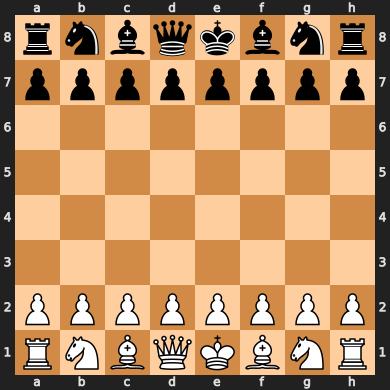

In [ ]:
boardplay = chess.Board()
boardplay


Game is over!
Result: 1/2-1/2


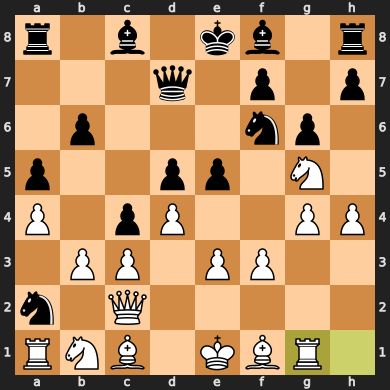

In [ ]:

AI_move = get_ai_move(boardplay)

try:
    boardplay.push(AI_move)

except:

    print("Game is over!")
    print("Result:", boardplay.result())
    
boardplay